## Predicting Insurance Claims filed by Travelling Agencies

In [5]:
import pandas as pd
import numpy as np
from scipy import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from collections import Counter

In [7]:
# import warnings
# from sklearn.exceptions import DataConversionWarning
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# from sklearn.exceptions import FitFailedWarning
# warnings.filterwarnings("ignore", category=FitFailedWarning)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
df=pd.read_csv('travel insurance.csv',sep=',')
row,column=df.shape
print("The dataset has {} Rows and {} Columns".format(row,column))
print('')
cols=list(df.columns)
continous=list(set(df._get_numeric_data().columns)-{'Duration','Age'})
print("Columns : ",cols)
print("Continous Variables   : ",continous)
categorical=list(set(cols)-set(continous))
print("Categorical Variables : ",categorical)
# Duration and Age are categorical ( done in EDA part [Ayush_Project.ipynb] )
df_=df.copy()
df_['Gender']=df_['Gender'].fillna('N')

The dataset has 63326 Rows and 11 Columns

Columns :  ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Gender', 'Age']
Continous Variables   :  ['Commision (in value)', 'Net Sales']
Categorical Variables :  ['Claim', 'Agency Type', 'Product Name', 'Agency', 'Destination', 'Distribution Channel', 'Gender', 'Age', 'Duration']


In [9]:
a=list(df_['Destination'].unique())
aa=list(df_['Agency'].unique())

In [10]:
df_ = df_[df_.Age != 118]
df_ = df_[df_.Duration >=0]
print("Now the dataset  has {} Rows and {} Columns".format(df_.shape[0],df_.shape[1]))
print("%d records deleted from the dataset"%(df.shape[0]-df_.shape[0]))
df_=df_.reset_index().drop(columns='index')
df1=df_.copy()

Now the dataset  has 62342 Rows and 11 Columns
984 records deleted from the dataset


In [11]:
b=list(df_['Destination'].unique())
bb=list(df_['Agency'].unique())

In [12]:
new=[]
for i in a :
  if(i not in list(b)):
    print(i)
    new.append(i)
for i in aa:
  if(i not in list(bb)):
    print(i)
    new.append(i)

KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF
TIBET
JWT


In [13]:
df.loc[df['Destination'].isin(new) ]#| df['Agency'].isin(new)]

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
10,JZI,Airlines,Online,Basic Plan,No,33,"KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF",-26.0,9.1,NaN,118
56265,EPX,Travel Agency,Offline,2 way Comprehensive Plan,No,29,TIBET,24.0,0.0,NaN,118


In [14]:
# Label Encoding
le=LabelEncoder()
le_df=pd.DataFrame()
for i in list(set(df_.columns)-set(df_._get_numeric_data().columns)):
  le_df[i]=le.fit_transform(df_[i])
for j in list(df_._get_numeric_data().columns):
  le_df[j]=df_[j]
print("Label Encoded dataset  has {} Rows and {} Columns".format(le_df.shape[0],le_df.shape[1]))

Label Encoded dataset  has 62342 Rows and 11 Columns


In [15]:
relation=dict()
for l in list(set(df_.columns)-set(df_._get_numeric_data().columns)):
  indx=[]
  for x in df_[l].unique():
    #print(x,' ',df_.index[df_[l] == x].tolist()[0])
    indx.append(df_.index[df_[l] == x].tolist()[0])
  dic=dict(zip(le_df.loc[indx][l].to_list(),df_.loc[indx][l].to_list()))
  relation[l]=dic
  print(dic)

{0: 'No', 1: 'Yes'}
{1: 'Travel Agency', 0: 'Airlines'}
{12: 'Comprehensive Plan', 16: 'Rental Vehicle Excess Insurance', 25: 'Value Plan', 8: 'Basic Plan', 15: 'Premier Plan', 1: '2 way Comprehensive Plan', 9: 'Bronze Plan', 17: 'Silver Plan', 4: 'Annual Silver Plan', 10: 'Cancellation Plan', 0: '1 way Comprehensive Plan', 22: 'Ticket Protector', 2: '24 Protect', 13: 'Gold Plan', 3: 'Annual Gold Plan', 20: 'Single Trip Travel Protect Silver', 14: 'Individual Comprehensive Plan', 21: 'Spouse or Parents Comprehensive Plan', 7: 'Annual Travel Protect Silver', 19: 'Single Trip Travel Protect Platinum', 5: 'Annual Travel Protect Gold', 18: 'Single Trip Travel Protect Gold', 6: 'Annual Travel Protect Platinum', 11: 'Child Comprehensive Plan', 23: 'Travel Cruise Protect', 24: 'Travel Cruise Protect Family'}
{3: 'CBH', 6: 'CWT', 8: 'JZI', 9: 'KML', 7: 'EPX', 2: 'C2B', 11: 'RAB', 12: 'SSI', 1: 'ART', 5: 'CSR', 4: 'CCR', 0: 'ADM', 10: 'LWC', 14: 'TTW', 13: 'TST'}
{78: 'MALAYSIA', 4: 'AUSTRALIA'

In [16]:
#OneHotEncoding
ohe=OneHotEncoder()
ohe_df=df_.copy()
for i in list(set(df_.columns)-set(df_._get_numeric_data().columns)-{'Claim'}):
  ohe_df = pd.get_dummies(ohe_df, columns=[i], prefix=[i] )
ohe_df=ohe_df.drop(columns='Claim')
print("One Hot Encoded dataset  has {} Rows and {} Columns".format(ohe_df.shape[0],ohe_df.shape[1]))

One Hot Encoded dataset  has 62342 Rows and 199 Columns


In [17]:
def print_result(y_test,y_pred):
  print("Confusion Matrix       : \n" ,confusion_matrix(y_test,y_pred))
  print("Accuracy of Model      : ",accuracy_score(y_test, y_pred))
  print("Precision of Model     : ",precision_score(y_test, y_pred))
  print("Recall of Model        : " , recall_score(y_test, y_pred))
  print("F1 Score of Model      : " ,f1_score(y_test, y_pred))
  print("ROC_AUC score of Model : " ,roc_auc_score(y_test,y_pred))	
  fpr, tpr, thresholds = roc_curve(y_test,y_pred)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% roc_auc_score(y_test,y_pred))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='best')

In [18]:
def print_input(X_train, X_test, y_train, y_test):
  print("TRAIN(X_train) Feature set        : ",len(X_train))
  print("TRAIN(y_train) Label Feature set  : ",len(y_train))
  print("TEST (X_test)  Feature set        : ",len(X_test))
  print("TEST (y_test)  Label set          : ",len(y_test))
  print("-------For Training Set--------\n")
  print(y_train['Claim'].value_counts())
  l_1,l_2= y_train['Claim'].value_counts()
  print("Class Label 0 is : ",(l_1/y_train.shape[0])*100,"%")
  print("Class Label 1 is : ",(l_2/y_train.shape[0])*100,"%")
  print("\n-------For Testing Set--------\n")
  print(y_test['Claim'].value_counts())
  l_1,l_2= y_test['Claim'].value_counts()
  print("Class Label 0 is : ",(l_1/y_test.shape[0])*100,"%")
  print("Class Label 1 is : ",(l_2/y_test.shape[0])*100,"%")

In [19]:
def balance(X_train,y_train,typ,s=0.3):
  if(typ.lower() == 'ros'):
    rus=RandomOverSampler(random_state=21)
    x_res, y_res = rus.fit_sample(X_train, y_train)
    print('Dataset shape after Random Over Sampling', Counter(y_res))
    print('After ROS the number of Rows Training set has are  : ', x_res.shape[0])
  elif(typ.lower() == 'rus' ):
    ros=RandomUnderSampler(random_state=21)
    x_res, y_res = ros.fit_sample(X_train, y_train)
    print('Dataset shape after Random Under Sampling', Counter(y_res))
    print('After RUS the number of Rows Training set has are : ', x_res.shape[0])
  elif(typ.lower() == 'adasyn'):
    ada=ADASYN(random_state=21, sampling_strategy=s, n_jobs=-1)
    x_res, y_res = ada.fit_sample(X_train, y_train)
    print('Dataset shape after ADASYN', Counter(y_res))
    print('After ADASYN the number of Rows Training set has are : ', x_res.shape[0])
  elif(typ.lower() == 'smote'):
    smo=SMOTE(random_state=21, sampling_strategy=s, n_jobs=-1)
    x_rs, y_rs = smo.fit_sample(X_train, y_train)
    tom=TomekLinks(random_state=21)
    x_res, y_res = tom.fit_sample(x_rs,y_rs)
    print('Dataset shape after SMOTE + Tomek Links', Counter(y_res))
    print('After SMOTE Tomek the number of Rows Training set has are : ', x_res.shape[0])
  return x_res, y_res


In [20]:
def plt_scatter(tmp_sample):
  plt.figure(figsize=(10,10))
  sns.scatterplot(x='Component 1',y='Component 2', hue='Label', data=tmp_sample)
  plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)


In [21]:
def plt_print(temp):
  tmp_sample = temp.sample(frac = 0.10, random_state=21)
  tmp_sample = tmp_sample[tmp_sample['Component 1'] < 0.90 ]
  print(tmp_sample['Label'].value_counts())
  l_1,l_2= tmp_sample['Label'].value_counts()
  print("Class Label 0 is : ",(l_1/tmp_sample.shape[0])*100,"%")
  print("Class Label 1 is : ",(l_2/tmp_sample.shape[0])*100,"%")
  print(" ")
  plt_scatter(tmp_sample)

In [22]:
def plot_graph(X_train,y_train):
  pca=PCA(n_components=2) 
  dim=pca.fit_transform(X_train)
  scaler=MinMaxScaler()
  res=scaler.fit_transform(dim)
  temp= pd.DataFrame(res,columns=['Component 1', 'Component 2'])
  y_temp=y_train.copy()
  y_temp=y_temp.reset_index()
  temp['Label'] = y_temp['Claim']
  plt_print(temp)

In [23]:
def plt_graph(X_train,y_train):
  pca=PCA(n_components=2) 
  dim=pca.fit_transform(X_train)
  scaler=MinMaxScaler()
  res=scaler.fit_transform(dim)
  temp= pd.DataFrame(res,columns=['Component 1', 'Component 2'])
  y_temp=y_train.copy()
  temp['Label'] = y_temp
  plt_print(temp)

In [24]:
target = pd.DataFrame(le_df['Claim'])
le_df=le_df.drop(columns='Claim')

### Splitting and Plotting 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(ohe_df,target,test_size = 0.25, random_state = 21, stratify = target)
print_input(X_train, X_test, y_train, y_test)
print("\n********Balancing the imbalanced class********\n")
print("\nRandom Under Sampling")
X_u_train, y_u_train = balance(X_train, y_train.values.ravel(),'rus')
print("\nRandom Over Sampling")
X_o_train, y_o_train = balance(X_train, y_train.values.ravel(),'ros')
print("\nSMOTE + Tomek Links (sampling_strategy = 0.3)")
X_s_train, y_s_train = balance(X_train, y_train.values.ravel(),'smote')
print("\nADASYN (sampling_strategy = 0.3)")
X_a_train, y_a_train = balance(X_train, y_train.values.ravel(),'adasyn')

TRAIN(X_train) Feature set        :  46756
TRAIN(y_train) Label Feature set  :  46756
TEST (X_test)  Feature set        :  15586
TEST (y_test)  Label set          :  15586
-------For Training Set--------

0    46068
1      688
Name: Claim, dtype: int64
Class Label 0 is :  98.52853109761314 %
Class Label 1 is :  1.4714689023868595 %

-------For Testing Set--------

0    15357
1      229
Name: Claim, dtype: int64
Class Label 0 is :  98.53073270884127 %
Class Label 1 is :  1.4692672911587321 %

********Balancing the imbalanced class********


Random Under Sampling
Dataset shape after Random Under Sampling Counter({0: 688, 1: 688})
After RUS the number of Rows Training set has are :  1376

Random Over Sampling
Dataset shape after Random Over Sampling Counter({0: 46068, 1: 46068})
After ROS the number of Rows Training set has are  :  92136

SMOTE + Tomek Links (sampling_strategy = 0.3)
Dataset shape after SMOTE + Tomek Links Counter({0: 45696, 1: 13820})
After SMOTE Tomek the number of Rows

0    4606
1      70
Name: Label, dtype: int64
Class Label 0 is :  98.50299401197606 %
Class Label 1 is :  1.4970059880239521 %
 


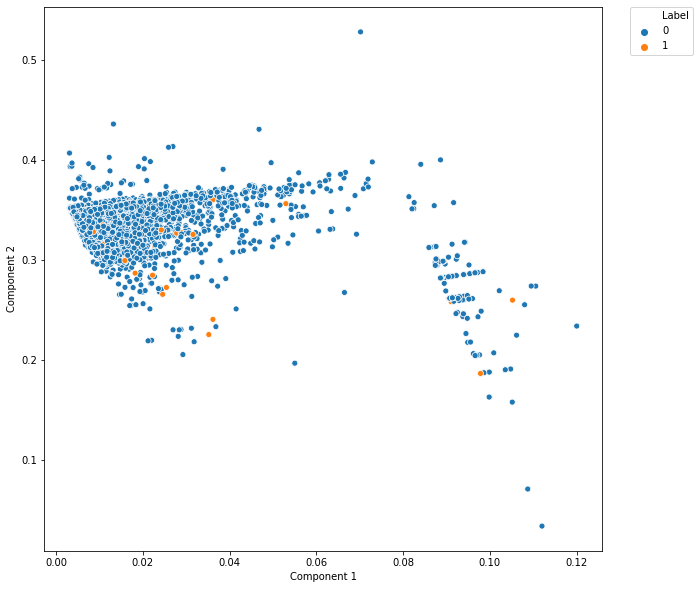

In [26]:
# No Sampling 
plot_graph(X_train,y_train)

1    69
0    69
Name: Label, dtype: int64
Class Label 0 is :  50.0 %
Class Label 1 is :  50.0 %
 


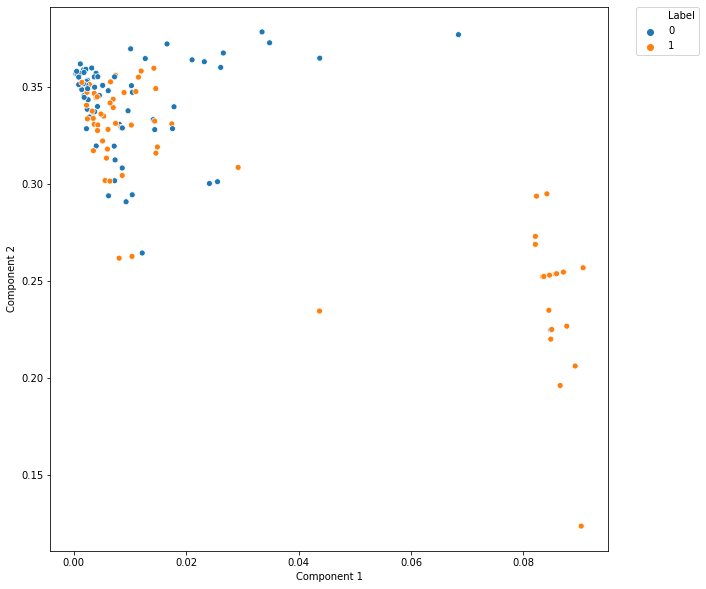

In [27]:
#under Sampling
plt_graph(X_u_train,y_u_train)

0    4634
1    4578
Name: Label, dtype: int64
Class Label 0 is :  50.30395136778115 %
Class Label 1 is :  49.69604863221885 %
 


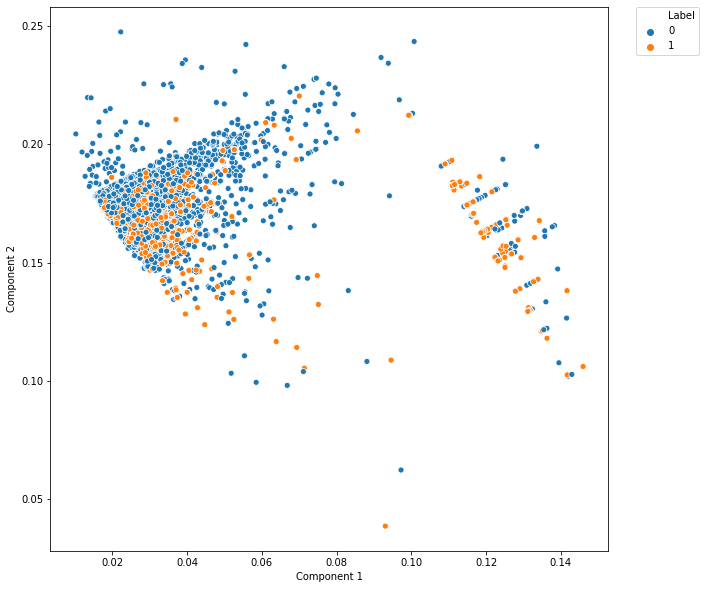

In [28]:
#over sampling
plt_graph(X_o_train,y_o_train)

0    4532
1    1419
Name: Label, dtype: int64
Class Label 0 is :  76.15526802218115 %
Class Label 1 is :  23.844731977818853 %
 


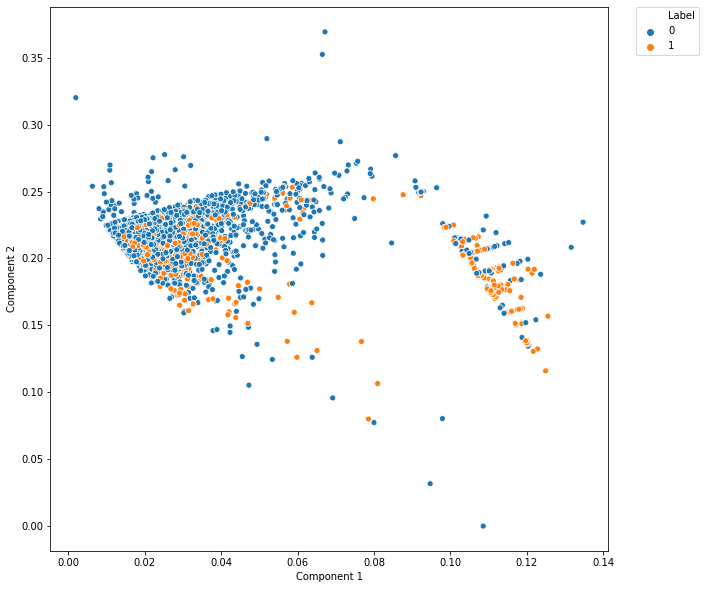

In [29]:
#SMOTE + Tomek
plt_graph(X_s_train,y_s_train)

0    4547
1    1461
Name: Label, dtype: int64
Class Label 0 is :  75.68242343541944 %
Class Label 1 is :  24.31757656458056 %
 


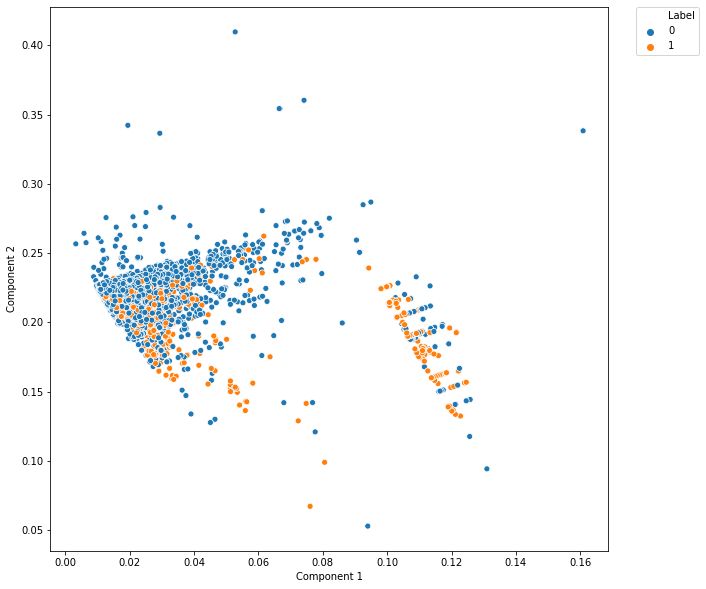

In [30]:
#ADASYN
plt_graph(X_a_train,y_a_train)

## Model Training [ Hyperparameter Tuning ( One Hot Encoding) ]


#### **Logistic Regression**

In [ ]:
logistic_regression=LogisticRegression()
param_grid={'class_weight':['balanced'],
            'max_iter':[40,100,500],
               'multi_class':['ovr'],
               'solver':['sag','newton-cg','lbfgs'],
            'penalty':['l2'],
            'C':[0.2,1.0]}

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternativ

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=40, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Confusion Matrix       : 
 [[12396  2961]
 [   69   160]]
Accuracy of Model      :  0.8055947645322725
Precision of Model     :  0.0512656199935918
Recall of Model        :  0.6986899563318777
F1 Score of Model      :  0.0955223880597015
ROC_AUC score of Model :  0.7529394302073531


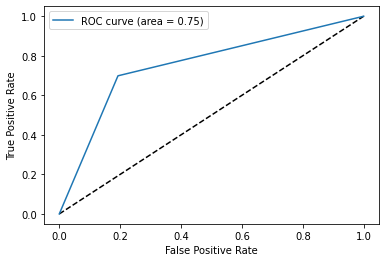

In [ ]:
log_reg=GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv= 3)
log_reg.fit(X_train, y_train.values.ravel())
logistic_reg_best_dt = log_reg.best_estimator_
print(logistic_reg_best_dt)
y_pred = logistic_reg_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternativ

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=40, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Confusion Matrix       : 
 [[12133  3224]
 [   61   168]]
Accuracy of Model      :  0.7892339278839985
Precision of Model     :  0.049528301886792456
Recall of Model        :  0.7336244541484717
F1 Score of Model      :  0.09279204639602319
ROC_AUC score of Model :  0.7618438087633679


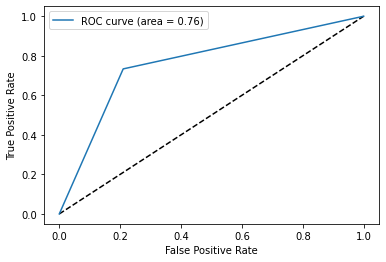

In [ ]:
### Random Under Sampling
log_reg=GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv= 3)
log_reg.fit(X_u_train, y_u_train)
logistic_reg_best_dt = log_reg.best_estimator_
print(logistic_reg_best_dt)
y_pred = logistic_reg_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternativ

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=40, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Confusion Matrix       : 
 [[12112  3245]
 [   63   166]]
Accuracy of Model      :  0.7877582445784679
Precision of Model     :  0.04866608032834946
Recall of Model        :  0.7248908296943232
F1 Score of Model      :  0.09120879120879122
ROC_AUC score of Model :  0.7567932692458071


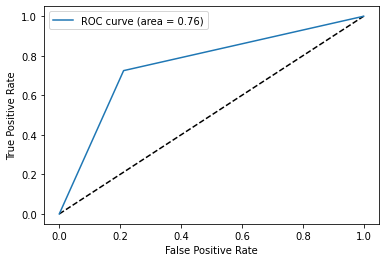

In [ ]:
### Random Over Sampling
log_reg=GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv= 3)
log_reg.fit(X_o_train, y_o_train)
logistic_reg_best_dt = log_reg.best_estimator_
print(logistic_reg_best_dt)
y_pred = logistic_reg_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternativ

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=40, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Confusion Matrix       : 
 [[12613  2744]
 [   74   155]]
Accuracy of Model      :  0.8191967150006416
Precision of Model     :  0.05346671265953777
Recall of Model        :  0.6768558951965066
F1 Score of Model      :  0.09910485933503838
ROC_AUC score of Model :  0.7490875816413606


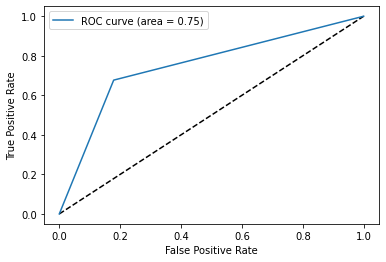

In [ ]:
### SMOTE + Tomek Links 0.3
log_reg=GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv= 3)
log_reg.fit(X_s_train, y_s_train)
logistic_reg_best_dt = log_reg.best_estimator_
print(logistic_reg_best_dt)
y_pred = logistic_reg_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

Dataset shape after SMOTE + Tomek Links Counter({0: 45752, 1: 23034})
After SMOTE Tomek the number of Rows Training set has are :  68786


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHE

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=40, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Confusion Matrix       : 
 [[12269  3088]
 [   64   165]]
Accuracy of Model      :  0.7977672269985885
Precision of Model     :  0.05072241008300031
Recall of Model        :  0.7205240174672489
F1 Score of Model      :  0.09477311889718554
ROC_AUC score of Model :  0.7597215385897161


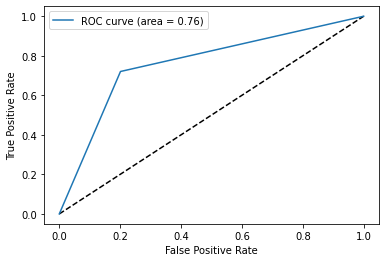

In [ ]:
### SMOTE + Tomek Links 0.5
X_s_train, y_s_train = balance(X_train, y_train.values.ravel(),'smote',0.5)
log_reg=GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv= 3)
log_reg.fit(X_s_train, y_s_train)
logistic_reg_best_dt = log_reg.best_estimator_
print(logistic_reg_best_dt)
y_pred = logistic_reg_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

Dataset shape after SMOTE + Tomek Links Counter({0: 45831, 1: 32247})
After SMOTE Tomek the number of Rows Training set has are :  78078


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of ite

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Confusion Matrix       : 
 [[12241  3116]
 [   64   165]]
Accuracy of Model      :  0.7959707429744642
Precision of Model     :  0.05028954587016154
Recall of Model        :  0.7205240174672489
F1 Score of Model      :  0.09401709401709402
ROC_AUC score of Model :  0.758809902202401


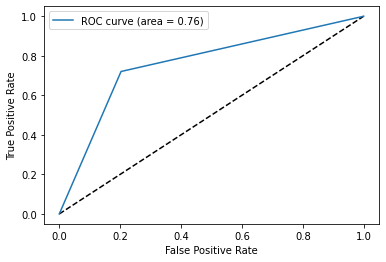

In [ ]:
### SMOTE + Tomek Links 0.7
X_s_train, y_s_train = balance(X_train, y_train.values.ravel(),'smote',0.7)
log_reg=GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv= 3)
log_reg.fit(X_s_train, y_s_train)
logistic_reg_best_dt = log_reg.best_estimator_
print(logistic_reg_best_dt)
y_pred = logistic_reg_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHE

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=40, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Confusion Matrix       : 
 [[12553  2804]
 [   74   155]]
Accuracy of Model      :  0.8153471063775183
Precision of Model     :  0.05238256167624197
Recall of Model        :  0.6768558951965066
F1 Score of Model      :  0.0972396486825596
ROC_AUC score of Model :  0.7471340750971138


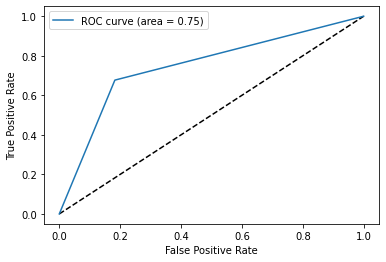

In [ ]:
### ADASYN 0.3
log_reg=GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv= 3)
log_reg.fit(X_a_train, y_a_train)
logistic_reg_best_dt = log_reg.best_estimator_
print(logistic_reg_best_dt)
y_pred = logistic_reg_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

Dataset shape after ADASYN Counter({0: 46068, 1: 22892})
After ADASYN the number of Rows Training set has are :  68960


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHE

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Confusion Matrix       : 
 [[12236  3121]
 [   66   163]]
Accuracy of Model      :  0.7955216219684332
Precision of Model     :  0.04963459196102314
Recall of Model        :  0.7117903930131004
F1 Score of Model      :  0.0927981781952747
ROC_AUC score of Model :  0.7542802977633061


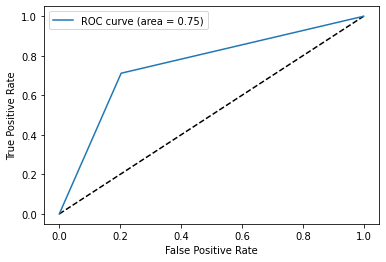

In [ ]:
### ADASYN 0.5
X_a_train, y_a_train = balance(X_train, y_train.values.ravel(),'adasyn',0.5)
log_reg=GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv= 3)
log_reg.fit(X_a_train, y_a_train)
logistic_reg_best_dt = log_reg.best_estimator_
print(logistic_reg_best_dt)
y_pred = logistic_reg_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

Dataset shape after SMOTE + Tomek Links Counter({0: 45831, 1: 32247})
After SMOTE Tomek the number of Rows Training set has are :  78078


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of ite

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Confusion Matrix       : 
 [[12241  3116]
 [   64   165]]
Accuracy of Model      :  0.7959707429744642
Precision of Model     :  0.05028954587016154
Recall of Model        :  0.7205240174672489
F1 Score of Model      :  0.09401709401709402
ROC_AUC score of Model :  0.758809902202401


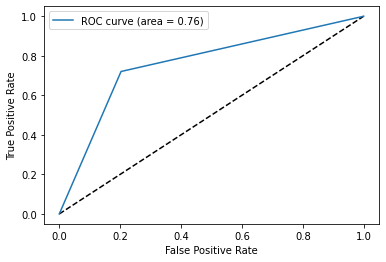

In [ ]:
### ADASYN 0.7
X_a_train, y_a_train = balance(X_train, y_train.values.ravel(),'smote',0.7)
log_reg=GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv= 3)
log_reg.fit(X_a_train, y_a_train)
logistic_reg_best_dt = log_reg.best_estimator_
print(logistic_reg_best_dt)
y_pred = logistic_reg_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

#### **Random Forest**

In [ ]:
clf_dt = RandomForestClassifier()
param_grid = {
   'max_leaf_nodes': [ 40,50 ],
   'class_weight' : ['balanced'],
   'criterion' :['gini','entropy'] ,
   'max_depth' : [ 30, 50, 100 ],
   'min_samples_split': [ 2, 3, 4]
    }

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[13168  2189]
 [   85   144]]
Accuracy of Model      :  0.8540998331836264
Precision of Model     :  0.061723103300471496
Recall of Model        :  0.62882096069869
F1 Score of Model      :  0.11241217798594849
ROC_AUC score of Model :  0.7431400499267364


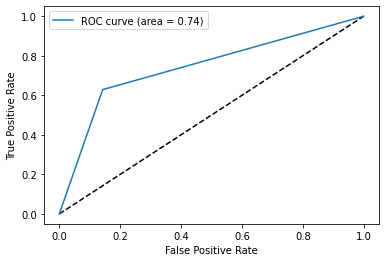

In [ ]:
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_train, y_train.values.ravel())
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_pred = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=40, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[12348  3009]
 [   68   161]]
Accuracy of Model      :  0.8025792377774926
Precision of Model     :  0.050788643533123026
Recall of Model        :  0.7030567685589519
F1 Score of Model      :  0.09473374521918211
ROC_AUC score of Model :  0.7535600310854926


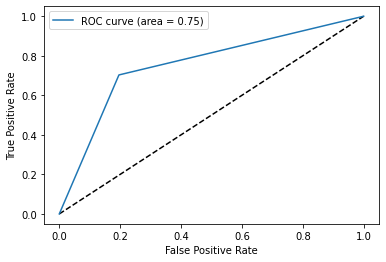

In [ ]:
### Random Under Sampling 
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_u_train, y_u_train)
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_pred = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[12985  2372]
 [   79   150]]
Accuracy of Model      :  0.8427434877454125
Precision of Model     :  0.05947660586835844
Recall of Model        :  0.6550218340611353
F1 Score of Model      :  0.10905125408942201
ROC_AUC score of Model :  0.750282291648006


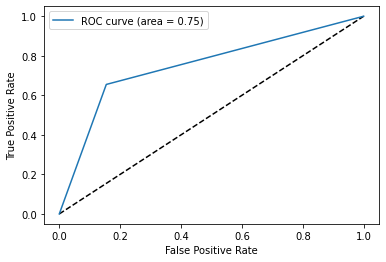

In [ ]:
### Random Over Sampling 
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_o_train, y_o_train)
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_pred = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=100, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[13325  2032]
 [   89   140]]
Accuracy of Model      :  0.8639163351725908
Precision of Model     :  0.06445672191528545
Recall of Model        :  0.611353711790393
F1 Score of Model      :  0.11661807580174927
ROC_AUC score of Model :  0.7395181009300341


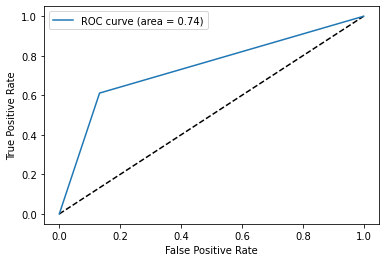

In [ ]:
### SMOTE + Tomek Links 
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_s_train, y_s_train)
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_pred = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

Dataset shape after SMOTE + Tomek Links Counter({0: 45752, 1: 23034})
After SMOTE Tomek the number of Rows Training set has are :  68786
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=30, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[13326  2031]
 [   90   139]]
Accuracy of Model      :  0.8639163351725908
Precision of Model     :  0.06405529953917051
Recall of Model        :  0.6069868995633187
F1 Score of Model      :  0.11588161734055856
ROC_AUC score of Model :  0.7373672532589011


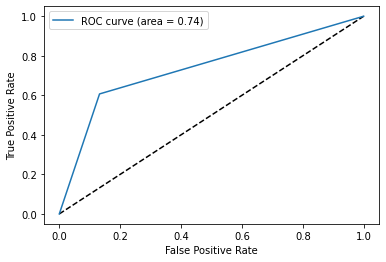

In [ ]:
### SMOTE + Tomek Links 0.5
X_s_train, y_s_train = balance(X_train, y_train.values.ravel(),'smote',0.5)
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_s_train, y_s_train)
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_pred = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

Dataset shape after SMOTE + Tomek Links Counter({0: 45831, 1: 32247})
After SMOTE Tomek the number of Rows Training set has are :  78078
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=30, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[13341  2016]
 [   89   140]]
Accuracy of Model      :  0.8649428974720903
Precision of Model     :  0.06493506493506493
Recall of Model        :  0.611353711790393
F1 Score of Model      :  0.11740041928721173
ROC_AUC score of Model :  0.7400390360085


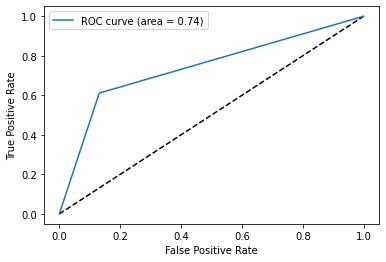

In [ ]:
### SMOTE + Tomek Links 0.7
X_s_train, y_s_train = balance(X_train, y_train.values.ravel(),'smote',0.7)
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_s_train, y_s_train)
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_pred = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

Dataset shape after ADASYN Counter({0: 46068, 1: 14018})
After ADASYN the number of Rows Training set has are :  60086
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=100, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[13300  2057]
 [   90   139]]
Accuracy of Model      :  0.862248171435904
Precision of Model     :  0.06329690346083788
Recall of Model        :  0.6069868995633187
F1 Score of Model      :  0.11463917525773194
ROC_AUC score of Model :  0.736520733756394


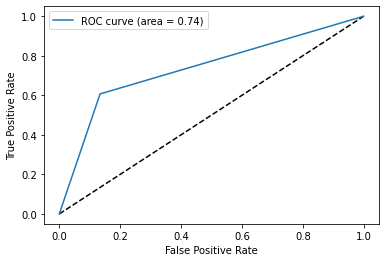

In [ ]:
### ADASYN
X_s_train, y_s_train = balance(X_train, y_train.values.ravel(),'adasyn',0.3)
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_a_train, y_a_train)
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_pred = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

Dataset shape after ADASYN Counter({0: 46068, 1: 22892})
After ADASYN the number of Rows Training set has are :  68960
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=30, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[13342  2015]
 [   90   139]]
Accuracy of Model      :  0.8649428974720903
Precision of Model     :  0.06453110492107707
Recall of Model        :  0.6069868995633187
F1 Score of Model      :  0.11665967268149391
ROC_AUC score of Model :  0.7378881883373669


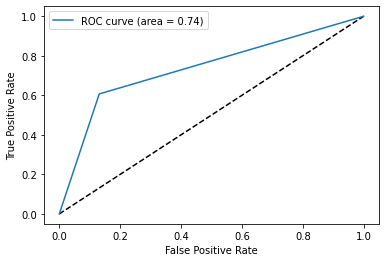

In [ ]:
### ADASYN 0.5
X_a_train, y_a_train = balance(X_train, y_train.values.ravel(),'adasyn',0.5)
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_a_train, y_a_train)
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_pred = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

Dataset shape after ADASYN Counter({0: 46068, 1: 32408})
After ADASYN the number of Rows Training set has are :  78476
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=100, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Confusion Matrix       : 
 [[13311  2046]
 [   88   141]]
Accuracy of Model      :  0.8630822533042474
Precision of Model     :  0.0644718792866941
Recall of Model        :  0.6157205240174672
F1 Score of Model      :  0.11672185430463575
ROC_AUC score of Model :  0.7412456888499135


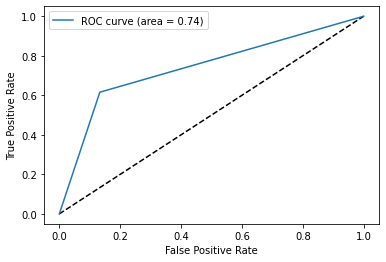

In [ ]:
### ADASYN 0.7
X_a_train, y_a_train = balance(X_train, y_train.values.ravel(),'adasyn',0.7)
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_a_train, y_a_train)
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_pred = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)